# 编程实践：量子模拟器

In [ ]:
# Numpy 是一个功能强大的Python库，主要用于对多维数组执行计算。
# Simulator 是模拟器，可以模拟量子计算机的计算过程。
import numpy as np                          # 导入numpy库并简写为np
from mindquantum.simulator import Simulator # 导入模拟器

# Simulator 中维护着一个量子态，初始为|0⟩态。
sim = Simulator('mqvector', 1)  # 实例化'mqvector'模拟器,量子比特数为1
print(sim)                      # 打印模拟器信息

In [ ]:
# 通过 set_qs() 可以将量子态设置为任意的非零列向量，接口会自动进行归一化。
plus_state = np.array([1, 1])   # 构造¦+⟩态
sim.set_qs(plus_state)          # 将量子态设置为¦+⟩态

quantum_state = sim.get_qs()    # 获取当前量子态
ket = sim.get_qs(ket=True)      # 获取当前量子态的狄拉克符号形式
print('quantum state:', quantum_state)
print('ket:\n', ket)

# 编程实践：量子门

In [ ]:
from mindquantum.core.gates import X, Y, H      # 导入量子门
from mindquantum.simulator import Simulator     # 导入模拟器

# 每个量子门都有 matrix() 方法，可以获取该量子门的矩阵形式。
print('Gate name:', X)
gateX = X.matrix()
print(gateX)

In [ ]:
print('Gate name:', Y)
gateY = Y.matrix()
print(gateY)

In [ ]:
print('Gate name:', H)
gateH = H.matrix()
print(gateH)

In [ ]:
# 调用 Simulator 的 apply_gate() 接口可以将量子门作用在量子比特上，使量子态发生演化。
# on() 方法可以指定量子门作用在哪个量子比特上（目标比特），受哪些比特控制（控制比特）。
sim = Simulator('mqvector', 1)          # 实例化一个模拟器
sim.apply_gate(H.on(0))                 # 将H门作用于q0
print(sim)

# 编程实践：量子线路

In [ ]:
from mindquantum.core.gates import X, Y, H   # 导入量子门X, Y, H
from mindquantum.core.circuit import Circuit # 导入Circuit模块，用于搭建量子线路
from mindquantum.simulator import Simulator  # 导入模拟器

# 通过“+=”的方式可以轻松地将量子门添加到量子线路中。
circ = Circuit() 			# 实例化一个量子线路
circ += H.on(0)  			# 在线路上的第0个比特添加一个H门
circ += Y.on(0) 			# 在线路上的第0个比特添加一个Y门
circ += X.on(1) 			# 在线路上的第1个比特添加一个X门

print(circ)

In [ ]:
mat = circ.matrix() 		# 获取线路对应的矩阵
print('circuit matrix:\n', mat)

In [ ]:
# 调用 Simulator 的 apply_circuit() 接口可以将量子线路作用在量子比特上，使量子态发生演化。
sim = Simulator('mqvector', 2)  	# 实例化一个两比特的模拟器
sim.apply_circuit(circ)          	# 作用量子线路
print(sim)

# 编程实践：量子测量

In [ ]:
from mindquantum.core.gates import Measure, H, X, Y # 导入量子门X, Y, H和量子测量Measure
from mindquantum.core.circuit import Circuit        # 导入Circuit模块，用于搭建量子线路
from mindquantum.simulator import Simulator         # 导入模拟器

circ = Circuit()                    # 实例化一个量子线路
circ += H.on(0)                     # 在线路上的第0个比特添加一个H门
circ += Y.on(0)                     # 在线路上的第0个比特添加一个Y门
circ += X.on(1)                     # 在线路上的第1个比特添加一个X门

# Measure 与量子门类似，可以用“+=”的方式添加到量子线路中，用 on() 方法指定目标比特。
circ += Measure().on(0)             # 在线路上的第0个比特添加一个测量
circ += Measure().on(1)             # 在线路上的第1个比特添加一个测量

print(circ)

In [ ]:
# 调用 Simulator 的 sampling() 接口可以对某一线路的演化结果进行多次采样，获得量子测量的统计结果。
# 这一过程与真实量子计算机的运行方式相似。
sim = Simulator('mqvector', 2)              # 实例化一个两比特的模拟器
result = sim.sampling(circ, shots=1000) 	# 对该线路的演化结果进行1000次采样
print(result)

# 编程实践：量子近似优化算法

In [ ]:
from mindquantum.algorithm import MaxCutAnsatz
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
import networkx as nx
import mindspore.nn as nn

# 构造待求解图
graph = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (0, 4), (0, 2)])
nx.draw(graph, with_labels=True)

In [ ]:
# 将图转化为目标哈密顿量
pauli_ops = QubitOperator()
for i in graph.edges:
    pauli_ops += QubitOperator(f'Z{i[0]} Z{i[1]}')
ham = Hamiltonian(pauli_ops)

# 构造线路
circ = MaxCutAnsatz(list(graph.edges), depth=4).circuit
circ.svg()

In [ ]:
# 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
sim = Simulator("mqvector", 5)

# 生成计算变分量子线路的期望值和梯度的算子
grad_ops = sim.get_expectation_with_grad(ham, circ)

# 生成待训练的神经网络
net = MQAnsatzOnlyLayer(grad_ops)

# 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)

# 生成能对神经网络进行一步训练的算子
train_net = nn.TrainOneStepCell(net, opti)

for i in range(200):

    # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    cut = (len(graph.edges) - train_net()) / 2

    # 每训练10步，打印当前训练步数和当前得到的切割边数
    if i % 10 == 0:
        print("train step:", i, ", cut:", cut)

# 作业1

1. 请搭建出如下线路。
2. 请打印线路运行后的量子态。
3. 请在线路末尾添加测量，并采样线路运行结果10000次，观察得到的分布。


<img src="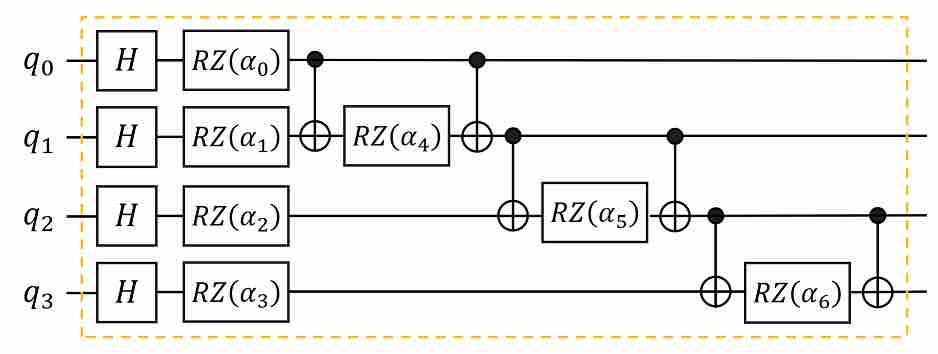
" width="400"/>

其中 $\alpha_0, \alpha_1, ⋯, \alpha_6$ 可以是任意值。

**预期结果：** 对于随意的 $\alpha_0, \alpha_1, ⋯, \alpha_6$ ，运行线路后的量子态应该难以发现规律，但添加测量后采样10000次的统计结果却是近似均匀分布。

**解释：** 该线路是IQP编码线路，可以将经典信息编码到量子态上。当选取RZ⻔时，RZ⻔只会改变相位信息，而不会改变振幅信息，即 $\alpha_0, \alpha_1, ⋯, \alpha_6$ 的信息将被编码至相位上。量子态中包含了振幅和相位的完整信息，因此难以发现规律；而采样得到的分布只与量子态的振幅有关，因此呈现均匀分布。

**请在标记为`#TODO`的位置完成代码编写，并将包裹代码的多行注释符`""" """`删除。每个TODO位置需要根据注释说明实现相应功能。**

In [ ]:
from mindquantum.core.gates import H, X, RZ
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator

"""
# TODO: 请根据图中所示构建量子线路
circ = Circuit()
# 在这里添加量子门...
"""

"""
# TODO: 使用模拟器运行线路，打印运行后的量子态
sim = Simulator('mqvector', circ.n_qubits)
# 在这里补充代码...
"""

"""
# TODO: 使用模拟器采样线路结果10000次
sim = Simulator('mqvector', circ.n_qubits)
res = # 在这里补充代码...

print(res)
"""


# 作业2：使用VQE算法计算氢分子的势能曲线

在本作业中，我们将使用变分量子本征求解器(VQE)算法来计算氢分子的势能曲线。具体步骤：

1. 使用给定的`get_H2_ham()`函数，根据不同的键长生成氢分子的哈密顿量。
2. 构建如下图所示的量子线路，并优化其参数以最小化哈密顿量的期望值。
3. 通过遍历不同的键长(0.5-1.1埃米)，计算对应的基态能量，绘制势能曲线。
4. 将VQE计算结果与完全组态相互作用(FCI)和Hartree-Fock(HF)方法的结果进行对比。

势能曲线展示了氢分子的基态能量如何随着两个氢原子间距离变化。曲线的最低点对应平衡键长，此时分子最稳定。当原子距离偏离平衡位置时，能量会升高：距离过小时由于核间排斥能量升高，距离过大时分子趋向解离。通过分析势能曲线，我们可以研究分子的稳定性、结合能和平衡构型等重要性质。

在这里，我们将VQE的结果与两种经典计算方法进行对比：
- 完全组态相互作用(FCI)方法：这是一种精确的量子化学计算方法，考虑了所有可能的电子组态，能得到最准确的结果，但计算成本随系统大小呈指数增长。FCI的结果将作为我们的参考标准。
- Hartree-Fock(HF)方法：这是一种近似方法，通过平均场近似来处理电子间的相互作用。HF方法计算速度快，但准确度较低，特别是在描述强关联体系时。

**请在标记为`#TODO`的位置完成代码编写，并将包裹代码的多行注释符`""" """`删除。每个TODO位置需要根据注释说明实现相应功能。**

> 注意： `openfermion`和`openfermionpyscf`仅支持Linux和MacOS，如果没有合适的环境，可以访问HiQ量子云平台中的Jupyter Lab服务。



<img src="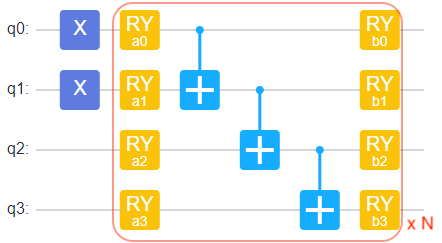
" width="400"/>

*Hartree-Fork + Hardware Efficient Ansatz*

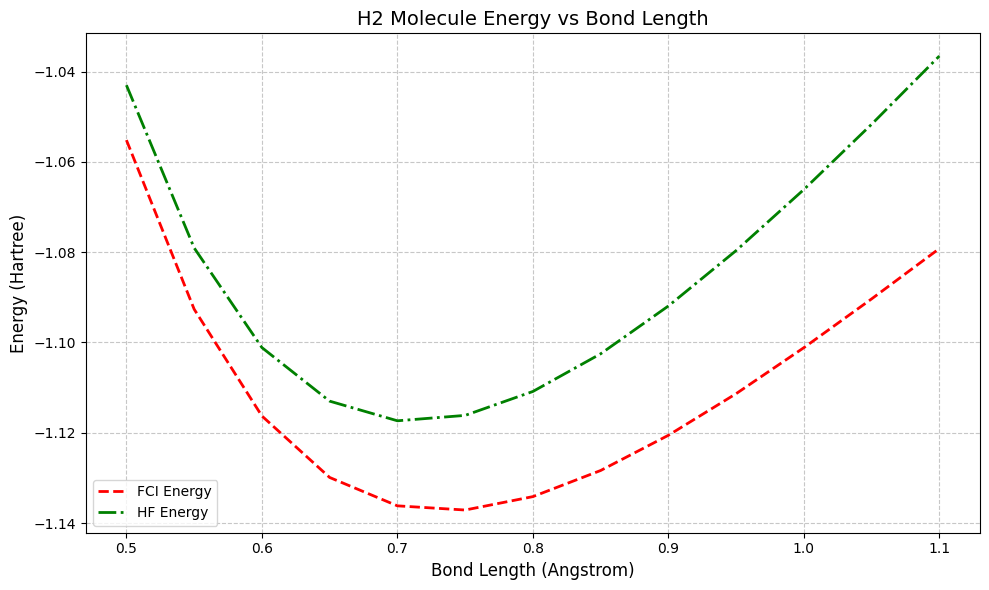

In [2]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from mindquantum.core.operators import Hamiltonian
from mindquantum.algorithm import get_qubit_hamiltonian, HardwareEfficientAnsatz
from mindquantum.core.gates import H, RY
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import numpy as np


def get_H2_ham(d):
    """
    根据键长生成H2分子哈密顿量
    Args:
        d (float): 键长，单位埃米
    Returns:
        Hamiltonian: H2分子哈密顿量
    """
    mol = MolecularData([("H", (0, 0, 0)), ("H", (0, 0, d))], "sto3g", multiplicity=1)
    mol = run_pyscf(mol, run_fci=1)
    return Hamiltonian(get_qubit_hamiltonian(mol)), mol.fci_energy, mol.hf_energy

"""
# TODO: 请根据图中所示构建量子线路
circ = Circuit()
# 在这里添加量子门...
"""

# Initialize lists to store results
distances = [i/20 for i in range(10, 23)]  # From 0.5 to 1.1 Angstrom with 0.05 step
energies = []
fci_energies = []
hf_energies = []

# Create simulator
sim = Simulator('mqvector', 4)

for d in distances:
    # Calculate Hamiltonian for current distance
    ham, fci_energy, hf_energy = get_H2_ham(d)

    fci_energies.append(fci_energy)
    hf_energies.append(hf_energy)

    """
    # TODO: 获取期望值和梯度算子
    grad_ops = # 在这里补充代码...

    def fun(x):
        # TODO: 计算期望值和梯度
        f, g = # 在这里补充代码...
        return f.real.squeeze(), g.real.squeeze()

    # TODO: 使用优化器最小化能量
    init_params = # 在这里补充代码...
    res = # 在这里补充代码...

    energies.append(res.fun)
    """

# Plot results
plt.figure(figsize=(10, 6))
if energies:
    plt.plot(distances, energies, 'b-', label='VQE Energy', linewidth=2)
plt.plot(distances, fci_energies, 'r--', label='FCI Energy', linewidth=2)
plt.plot(distances, hf_energies, 'g-.', label='HF Energy', linewidth=2)
plt.xlabel('Bond Length (Angstrom)', fontsize=12)
plt.ylabel('Energy (Hartree)', fontsize=12)
plt.title('H2 Molecule Energy vs Bond Length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
